Reference: https://num.pyro.ai/en/latest/examples/bnn.html

In [1]:
import jax
import numpyro
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro.distributions as dist

from jax import vmap, random
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, HMC
from utils import samples_to_df, df_to_samples, plot_ESS, plot_GR, plot_posterior

numpyro.set_platform("cpu")
numpyro.set_host_device_count(16)

rng_key = random.PRNGKey(np.random.randint(0, 1000))
rng_key_fit, rng_key_predict = random.split(rng_key)

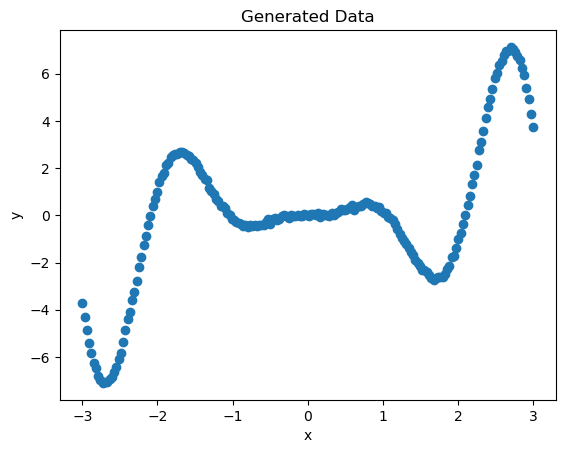

In [2]:
def generate_data(N, D_X, sigma, N_test):
    X = jnp.linspace(-3, 3, N)
    X = jnp.power(X[:,None], jnp.arange(D_X))

    Y = jnp.power(X[:,1], 2.0) * jnp.sin(3.0 * X[:,1])
    Y = Y + np.random.randn(N) * sigma

    X_test = jnp.linspace(-4, 4, N_test)
    X_test = jnp.power(X_test[:,None], jnp.arange(D_X))

    return X, Y, X_test

num_warmup = 10
num_samples = 10
num_chains = 5
N, N_test, sigma, D_X, D_H = 200, 1000, 0.05, 3, 3
X, Y, X_test = generate_data(N, D_X, sigma, N_test)

plt.scatter(X[:,1], Y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Generated Data")
plt.show()

In [3]:
def model_noncentered(X, Y, D_H):
    N, D_X = X.shape
    inv_sigma = numpyro.sample("inv_sigma", dist.Gamma(3.0, 1.0))
    sigma = numpyro.deterministic("sigma", 1 / inv_sigma)

    W_1 = numpyro.sample("W_1", dist.Normal(0, 1).expand((D_X, D_H)).to_event(2))
    W_2 = numpyro.sample("W_2", dist.Normal(0, 1).expand((D_H, D_H)).to_event(2))
    W_3 = numpyro.sample("W_3", dist.Normal(0, 1).expand((D_H,)).to_event(1))

    Z_1 = jnp.tanh(X @ W_1)
    Z_2 = jnp.tanh(Z_1 @ W_2)
    Z_3 = Z_2 @ W_3

    numpyro.sample("Y", dist.Normal(Z_3, sigma), obs=Y)

def model_centered(X, Y, D_H):
    N, D_X = X.shape
    inv_sigma = numpyro.sample("inv_sigma", dist.Gamma(3.0, 1.0))
    sigma = numpyro.deterministic("sigma", 1 / inv_sigma)
    X = X.transpose(tuple(range(1, X.ndim)) + (0,)) # X.shape == (D_X, N)

    X_scale = X[:D_X, :D_X] # X_scale.shape == (D_X, D_X)
    X_scale = X_scale / (abs(jnp.linalg.det(X_scale)) ** (1 / D_X))
    X_unit = jnp.linalg.inv(X_scale) @ X # X_unit.shape == (D_X, N)
    W_1 = numpyro.sample("W_1", dist.MultivariateNormal(0, X_scale.T @ X_scale).expand((D_H,)).to_event(1)) # W_1.shape == (D_H, D_X)
    Z_1 = jnp.tanh(W_1 @ X_unit) # Z_1.shape == (D_H, N)

    Z_1_scale = Z_1[:D_H, :D_H] # Z_1_scale.shape == (D_H, D_H)
    Z_1_scale = Z_1_scale / (abs(jnp.linalg.det(Z_1_scale)) ** (1 / D_H))
    Z_1_unit = jnp.linalg.inv(Z_1_scale) @ Z_1 # Z_1_unit.shape == (D_H, N)
    W_2 = numpyro.sample("W_2", dist.MultivariateNormal(0, Z_1_scale.T @ Z_1_scale).expand((D_H,)).to_event(1)) # W_2.shape == (D_H, D_H)
    Z_2 = jnp.tanh(W_2 @ Z_1_unit) # Z_2.shape == (D_H, N)

    Z_2_scale = Z_2[:D_H, :D_H] # Z_2_scale.shape == (D_H, D_H)
    Z_2_scale = Z_2_scale / (abs(jnp.linalg.det(Z_2_scale)) ** (1 / D_H))
    Z_2_unit = jnp.linalg.inv(Z_2_scale) @ Z_2 # Z_2_unit.shape == (D_H, N)
    W_3 = numpyro.sample("W_3", dist.MultivariateNormal(0, Z_2_scale.T @ Z_2_scale)) # W_3.shape == (D_H,)
    Z_3 = W_3 @ Z_2_unit # Z_3.shape == (N,)

    numpyro.sample("Y", dist.Normal(Z_3, sigma), obs=Y)

In [10]:
kernel = NUTS(model_centered)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc.run(rng_key_fit, X, Y, D_H)
mcmc.print_summary()
samples = mcmc.get_samples()
df = samples_to_df(samples)
df.to_csv("result/bnn.csv")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   W_1[0,0]      0.41      0.82      0.71     -1.18      0.99       nan       inf
   W_1[0,1]     -0.30      1.25     -0.55     -1.80      1.55       nan       inf
   W_1[0,2]     -0.29      1.36     -0.46     -1.93      1.96       nan       inf
   W_1[1,0]     -0.08      0.42     -0.09     -0.58      0.49       nan       inf
   W_1[1,1]      0.24      1.32      0.21     -1.80      1.88       nan 23194216.00
   W_1[1,2]      0.53      1.31      0.96     -1.26      1.89       nan       inf
   W_1[2,0]      1.27      0.42      1.29      0.58      1.79       nan 7418164.50
   W_1[2,1]      0.10      0.33      0.01     -0.24      0.63       nan       inf
   W_1[2,2]      0.34      0.92      0.37     -0.79      1.56       nan       inf
   W_2[0,0]     -0.24      0.72     -0.05     -1.30      0.78       nan       inf
   W_2[0,1]      0.43      1.09     -0.24     -0.72      1.84       nan       inf
   W_2[0,2] 

In [5]:
df = pd.read_csv("result/bnn.csv")
# samples = df_to_samples(df, params=["W_1", "W_2", "W_3", "inv_sigma", "sigma"], shapes=[(D_X, D_H), (D_H, D_H), (D_H,), (), ()])
samples = df_to_samples(df, params=["W_1", "W_2", "W_3", "inv_sigma", "sigma"], shapes=[(D_H, D_X), (D_H, D_H), (D_H,), (), ()])
print(samples)

def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    trace = handlers.trace(model).get_trace(X, None, D_H)
    return trace["Y"]["value"]

vmap_args = (samples, random.split(rng_key_predict, num_samples * num_chains))
predictions = vmap(lambda samples, rng_key: predict(model_centered, rng_key, samples, X_test, D_H))(*vmap_args)
# predictions = samples["Z_3"]

mid_prediction = np.median(predictions, axis=0)
low_prediction = np.percentile(predictions, 5.0, axis=0)
high_prediction = np.percentile(predictions, 95.0, axis=0)

plt.scatter(X[:,1], Y, marker="x", color="tab:blue", label="data")
# plt.plot(X[:,1], mid_prediction, color="tab:red", label="predict")
# plt.fill_between(X[:,1], low_prediction, high_prediction, color="tab:red", alpha=0.2)
plt.plot(X_test[:,1], mid_prediction, color="tab:red", label="predict")
plt.fill_between(X_test[:,1], low_prediction, high_prediction, color="tab:red", alpha=0.2)
plt.title("Mean predictions with 90% CI")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

{'W_1': array([[[-0.69729954, -0.8378258 , -1.0198686 ],
        [-1.5958393 , -0.6078962 ,  0.13099276],
        [-0.5254155 , -0.29232562,  0.05795265]],

       [[-0.66966826, -0.82020944, -1.0325489 ],
        [-1.5658314 , -0.6030243 ,  0.13333207],
        [-0.55495805, -0.3691229 ,  0.03157181]],

       [[-0.680438  , -0.8434617 , -1.030225  ],
        [-1.5852064 , -0.61407995,  0.14294298],
        [-0.586877  , -0.37016073,  0.02618141]],

       [[-0.6292811 , -0.80406   , -1.0237111 ],
        [-1.6005704 , -0.60981447,  0.15219867],
        [-0.6462453 , -0.35721076,  0.0171531 ]],

       [[-0.58528113, -0.7937093 , -1.0441782 ],
        [-1.6373926 , -0.6204053 ,  0.11528319],
        [-0.6441902 , -0.3934543 ,  0.01517632]],

       [[-0.5851935 , -0.78163606, -1.0552092 ],
        [-1.623965  , -0.6081527 ,  0.12993173],
        [-0.6402032 , -0.41965628,  0.02304007]],

       [[-0.6119666 , -0.8017149 , -1.0461581 ],
        [-1.6503491 , -0.6122845 ,  0.12288015],


ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (4 of them) had size 10, e.g. axis 0 of argument samples['W_1'] of type float32[10,3,3];
  * one axis had size 0: axis 0 of argument samples['sigma'] of type float32[0];
  * one axis had size 50: axis 0 of argument rng_key of type uint32[50,2]

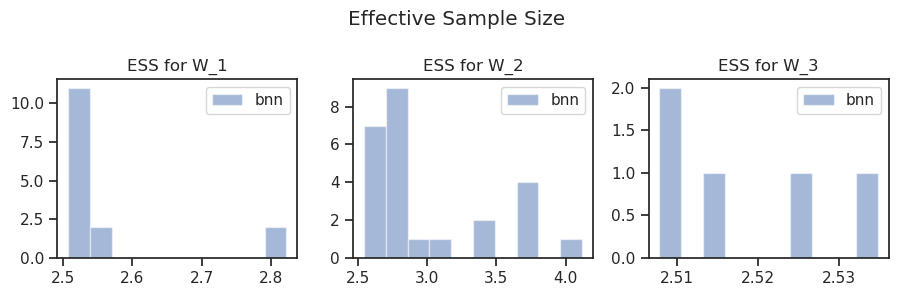

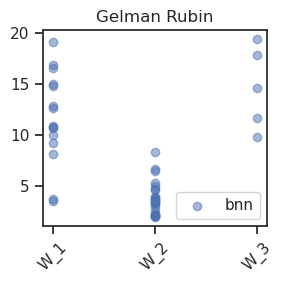

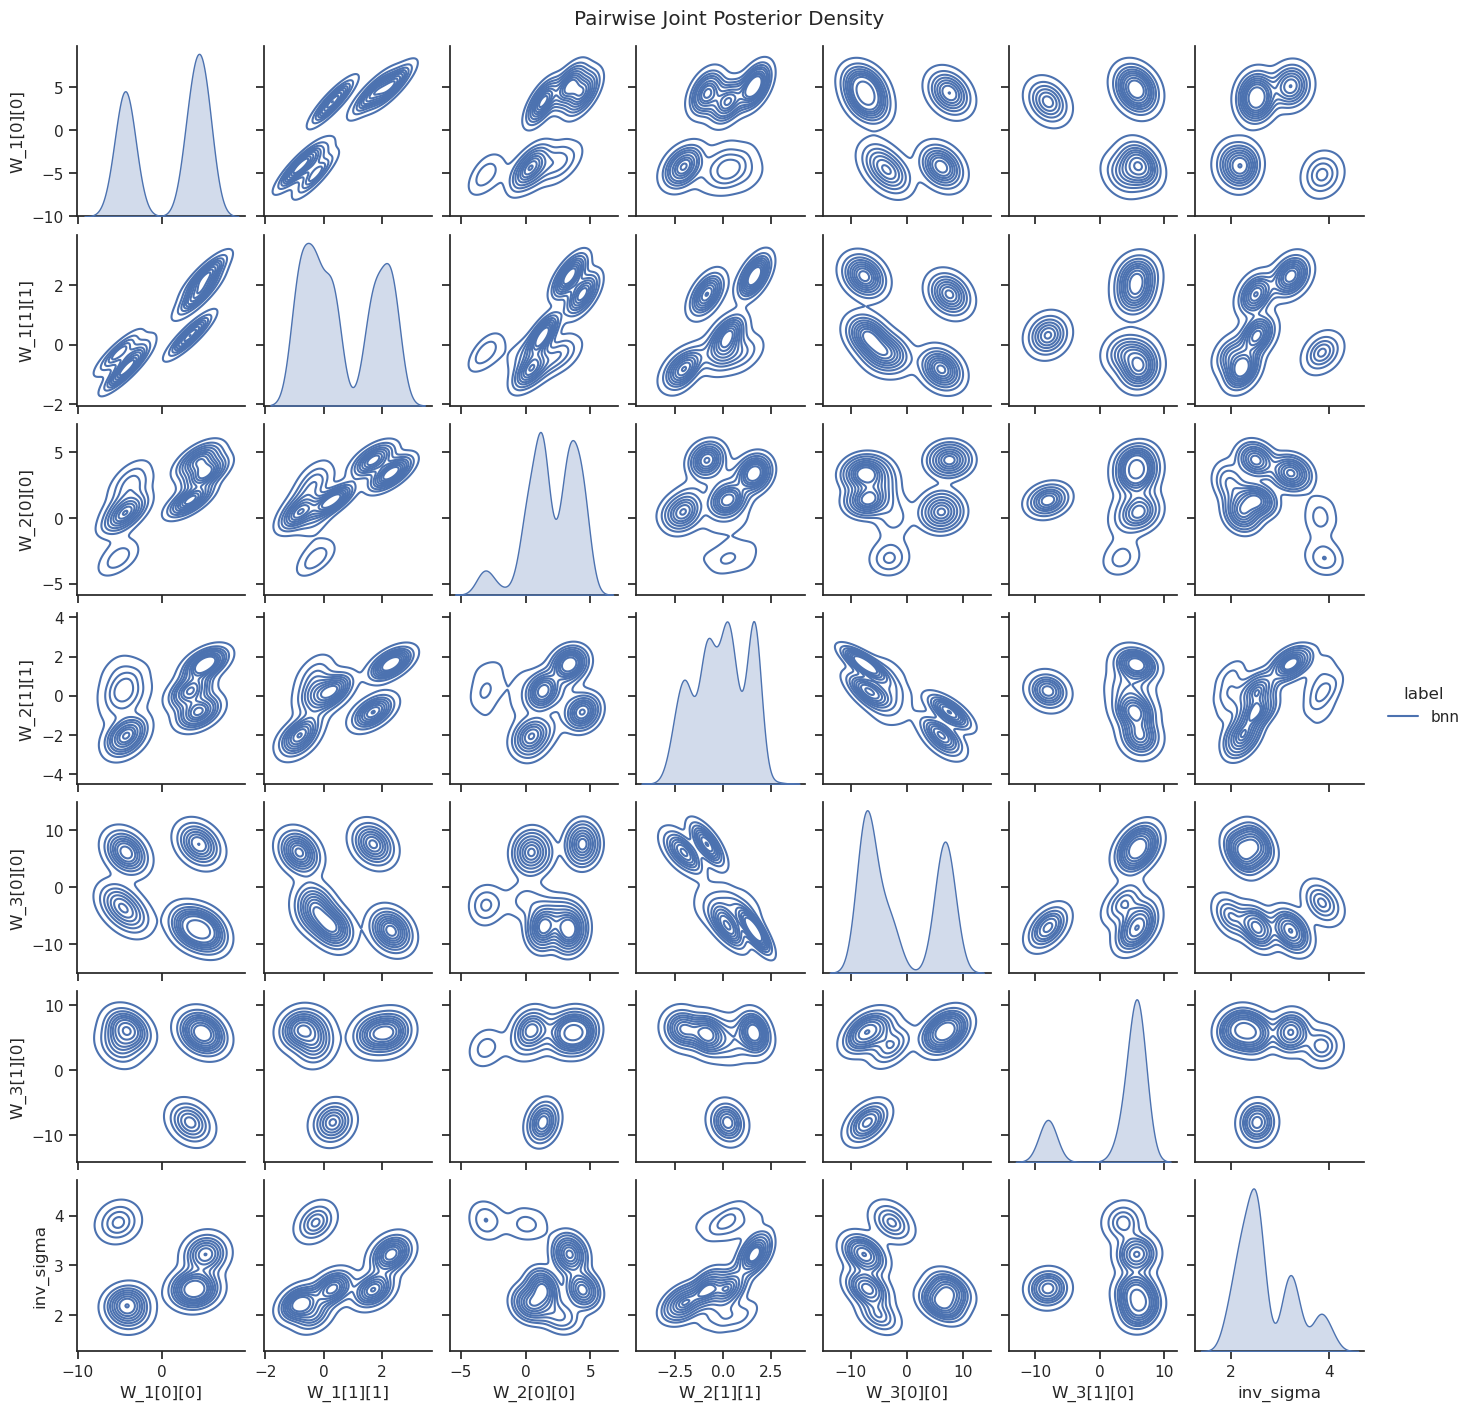

In [59]:
dfs = [df]
labels = ["bnn"]

plot_ESS(dfs, labels,
         params=["W_1", "W_2", "W_3"],
         num_chains=num_chains, num_samples=num_samples)

plot_GR(dfs, labels,
        params=["W_1", "W_2", "W_3"],
        num_chains=num_chains, num_samples=num_samples)

plot_posterior(dfs, labels,
               params=["W_1[0][0]", "W_1[1][1]", "W_2[0][0]", "W_2[1][1]", "W_3[0][0]", "W_3[1][0]", "inv_sigma"],
               num_subsamples=1000)